In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
# --- Read and process sample data ---
# Assume the file 'thingspeak_dataset.csv' has the following structure:
# created_at,entry_id,field1,field2,field3,field4,field5,field6,field7,field8
df = pd.read_csv('datasets/2881821.csv', parse_dates=['created_at'])

In [2]:
print(df.head())

                 created_at  entry_id  field1  field2  field3  field4  field5  \
0 2025-03-18 06:54:26+00:00         1     6.0     6.0     3.6     5.0     0.0   
1 2025-03-18 06:54:43+00:00         2     6.0     4.0     2.4     3.0    10.0   
2 2025-03-18 06:54:59+00:00         3     6.0     7.0     4.2     6.0     3.0   
3 2025-03-18 06:55:16+00:00         4     9.0     4.0     3.6     5.0    13.0   
4 2025-03-18 06:55:31+00:00         5     4.0     4.0     1.6     3.0    22.0   

   field6  field7  field8  
0     0.0     0.0     0.0  
1    10.0    10.0    10.0  
2     3.0     3.0     3.0  
3    13.0    13.0    13.0  
4    22.0    22.0    22.0  


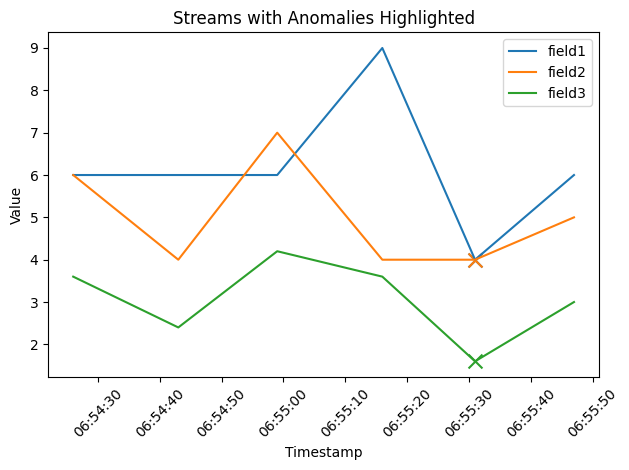

In [14]:
# --- Function to detect anomalies ---
def detect_anomalies(df, streams_to_check, start_time, end_time,
                     n_estimators=100, contamination=0.01):
    df_time = df[(df['created_at'] >= pd.to_datetime(start_time)) &
                 (df['created_at'] <= pd.to_datetime(end_time))].copy()
    X = df_time[streams_to_check]
    iso = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=42
    )
    iso.fit(X)
    df_time['anomaly_score'] = -iso.decision_function(X)
    df_time['is_anomaly'] = (iso.predict(X) == -1).astype(int)
    return df_time

# --- Apply anomaly detection ---
result = detect_anomalies(
    df,
    streams_to_check=['field1', 'field2', 'field3'],
    start_time='2025-03-18 06:54:00+00:00',
    end_time='2025-03-18 06:56:00+00:00',
    n_estimators=100,
    contamination=0.02
)

# --- Visualization: all three streams in one plot with anomalies highlighted ---
plt.figure()
streams = ['field1', 'field2', 'field3']
anomalies = result[result['is_anomaly'] == 1]

for stream in streams:
    plt.plot(result['created_at'], result[stream], label=stream)
    plt.scatter(
        anomalies['created_at'],
        anomalies[stream],
        marker='x',
        s=100
    )

plt.title('Streams with Anomalies Highlighted')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

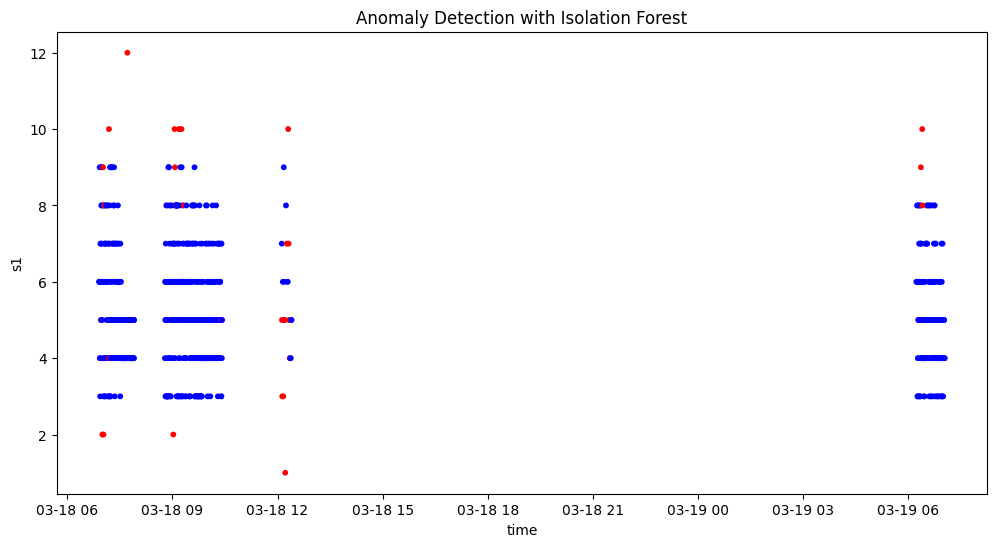

In [17]:
# Select features to use (exclude 'time')
features = ['field1', 'field2', 'field3']
X = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(X_scaled)

# Convert -1 to 1 (anomaly), 1 to 0 (normal)
df['is_anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Plot anomaly points over time for s1
plt.figure(figsize=(12, 6))
colors = df['is_anomaly'].map({0: 'blue', 1: 'red'})

plt.scatter(df['created_at'], df['field1'], c=colors, s=10)
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel('time')
plt.ylabel('s1')
plt.show()

In [18]:
# Step 2: Preprocessing the Data
# Drop non-numeric columns if any (or handle categorical variables appropriately)
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Fill missing values if needed
df_numeric = df_numeric.fillna(df_numeric.mean())

# Normalize the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [19]:
# Step 3: Fit the Isolation Forest Model
# Fit the model
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df_scaled)

# -1 indicates anomaly, 1 indicates normal
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

is_anomaly
0    736
1     39
Name: count, dtype: int64


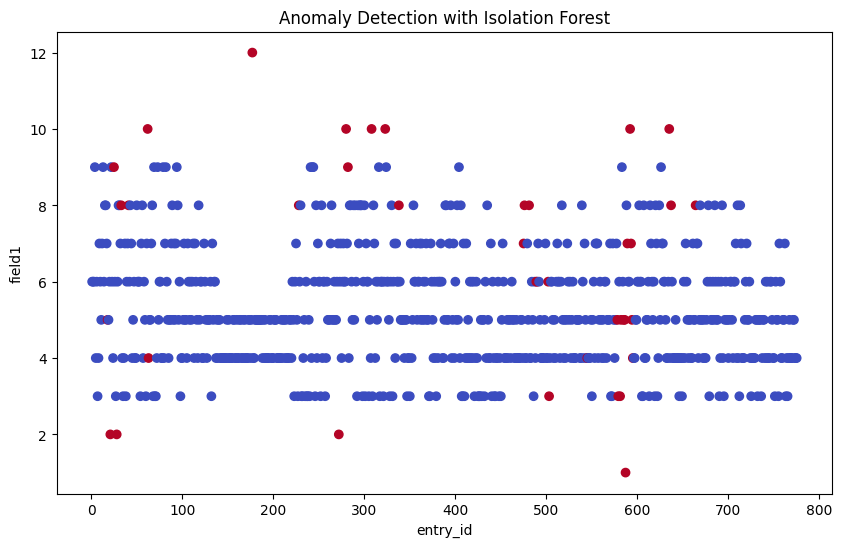

In [20]:
# Step 4: Analyze Results
# Count anomalies
print(df['is_anomaly'].value_counts())

# Optional: visualize anomalies
plt.figure(figsize=(10,6))
plt.scatter(df_numeric.iloc[:, 0], df_numeric.iloc[:, 1], c=df['is_anomaly'], cmap='coolwarm')
plt.title('Anomaly Detection with Isolation Forest')
plt.xlabel(df_numeric.columns[0])
plt.ylabel(df_numeric.columns[1])
plt.show()